In [152]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from d2l import torch as d2l
import math
from typing import Optional

In [153]:
# copy from q3 - q11

class PositionalEncoding(nn.Module):
    def __init__(self, input_dim, max_len=1000):
        super(PositionalEncoding, self).__init__()
        # 输入的维度为
        # batch_size * num_steps * num_hiddens
        # 则要对每一个时间步进行位置编码
        # 由于是固定位置编码，生成一个固定的位置矩阵就行了
        self.input_dim = input_dim
        self.max_len = max_len
        self.position_matrix = torch.zeros(1, max_len, input_dim)
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1   
        ) / torch.pow(10000, ( torch.arange(0, input_dim,dtype=torch.float32) / input_dim ))
        self.position_matrix[:, :, 0::2] = torch.sin(X[:, 0::2])
        self.position_matrix[:, :, 1::2] = torch.cos(X[:, 1::2])
        
        
    def forward(self,X):
        X = X + self.position_matrix[:, :X.shape[1], :].to(device=X.device, dtype=X.dtype)
        return X

# def masked_softmax(x, valid_lens, eps=1e-8):
#     # X为评分矩阵
#     # shape X: batch * num_steps * num_steps
#     if valid_lens is None:
#         return nn.functional.softmax(x, dim=1)
#     shape = x.shape
#     if valid_lens.dim() == 2:
#         valid_lens = valid_lens.reshape(-1)
#     mask_bool = torch.arange(shape[1], device=x.device).unsqueeze(0) >= valid_lens.unsqueeze(1)
#     mask_bool = mask_bool.unsqueeze(1).expand(-1, shape[1], -1)
#     print(f'mask_bool shape: {mask_bool.shape}')
#     x = x.masked_fill(mask_bool, eps)
#     return nn.functional.softmax(x, dim=1)

def masked_softmax(X, valid_lens):
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        # print(f"shape: {shape}")
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # print(f"valid_lens: {valid_lens}")
        # -1e6很小，使其非常小
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        # print(f"X.shape: {X.shape}")
        return nn.functional.softmax(X.reshape(shape), dim=-1)

class DotAttention(nn.Module):
    def __init__(self, **kwargs):
        super(DotAttention, self).__init__(**kwargs)
        
    def forward(self, q, k, v, valid_lens=None):
        d = q.shape[-1]
        score_matrix = torch.bmm(q, k.transpose(1, 2)) / math.sqrt(d)
        attention_weights = masked_softmax(score_matrix, valid_lens)

        return torch.bmm(attention_weights, v)
    
    
    
def transpose_qkv(X, num_heads):
    # X: batch * num_steps * num_hiddens
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    # X: batch * num_steps * num_head * (num_hiddens / num_head)
    X = X.permute(0, 2, 1, 3)
    # X: batch * num_head * num_steps * (num_hiddens / num_head)
    
    # final: (batch*num_head) * num_steps * (num_hiddens / num_head)
    return X.reshape(-1, X.shape[2], X.shape[3])


def transpose_output(X, num_heads):
    # X: (batch*num_head) * num_steps * (num_hiddens / num_head)
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1],-1)

class SimpleMultiHeadAttention(nn.Module):
    def __init__(self, q_size, k_size, v_size, num_hiddens, num_head,  **kwargs):
        super(SimpleMultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_head
        self.attention = DotAttention()
        self.W_q = nn.Linear(q_size, num_hiddens)
        self.W_k = nn.Linear(k_size, num_hiddens)
        self.W_v = nn.Linear(v_size, num_hiddens)
        self.W_out = nn.Linear(num_hiddens, num_hiddens)
        
        
    def forward(self, query, key, value, valid_lens=None):
        queries = transpose_qkv(self.W_q(query), self.num_heads)
        keys = transpose_qkv(self.W_k(key), self.num_heads)
        values = transpose_qkv(self.W_v(value), self.num_heads)
        
        if valid_lens is not None:
            # 重复head次
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0
            )
        # print(valid_lens)
        
        output = self.attention(queries, keys, values, valid_lens)
        output = transpose_output(output, num_heads=self.num_heads)
        return self.W_out(output)
    

class PositionWiseFeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, **kwargs):
        super(PositionWiseFeedForward, self).__init__(**kwargs)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [154]:
class AddNorm(nn.Module):
    def __init__(self, normalize_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        # normalize_shape 意思是需要归一化的维度大小
        self.ln = nn.LayerNorm(normalize_shape)
        
    def forward(self, X, Y):
        # 把输出的Y进行dropout之后，再和X进行残差连接
        return self.ln(self.dropout(Y) + X)
    

In [155]:
class TransformerBlock(nn.Module):
    def __init__(self, layer_id: int, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.layer_id = layer_id
    def forward(self,x: torch.Tensor,mask: Optional[torch.Tensor]):
        return

In [156]:
class TransformerEncoderBlock(TransformerBlock):
    def __init__(self, layer_id: int, query_size, key_size, value_size , num_hiddens, norm_shape, 
                 ffn_num_input, ffn__num_hiddens, num_heads, dropout, **kwargs):
        super(TransformerEncoderBlock, self).__init__(layer_id, **kwargs)
        self.attention = SimpleMultiHeadAttention(query_size, key_size, value_size, num_hiddens, num_heads)
        self.add_norm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFeedForward(ffn_num_input, ffn__num_hiddens, num_hiddens)
        self.add_norm2 = AddNorm(norm_shape, dropout)
    
    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor]):
        Y = self.add_norm1(x, self.attention(x,x,x, mask))
        return self.add_norm2(Y, self.ffn(Y))

In [157]:
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, query_size, key_size, value_size, num_hiddens, norm_shape, 
                 ffn_num_input, ffn_num_hiddens, num_heads,num_layers ,dropout,**kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.position_embedding = PositionalEncoding(num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("layer{}".format(i), 
                                 TransformerEncoderBlock(i, query_size, key_size, value_size, num_hiddens, norm_shape
                                                         , ffn_num_input, ffn_num_hiddens, num_heads, dropout))
    
    def forward(self, X, valid_lens):
        X = self.position_embedding(self.embedding(X) + math.sqrt(self.num_hiddens))
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
        return X

In [158]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5
)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens = torch.tensor([3, 2])).shape

torch.Size([2, 100, 24])

In [159]:
net = TransformerEncoder(8000, 24, 24, 24, 24, [24], 24, 48, 6, 5, 0.5)
net.eval()
test_X = torch.zeros((64, 10)).long()
print(f"rst shape is {net(test_X, None).shape}")

rst shape is torch.Size([64, 10, 24])


In [160]:
class TransformerDecoderBlock(TransformerBlock):
    def __init__(self, layer_id: int, query_size,key_size, value_size, num_hiddens, norm_shape,
                 ffn_num_input, ffn_num_hiddens, num_heads, dropout,  **kwargs):
        super(TransformerDecoderBlock, self).__init__(layer_id, **kwargs)
        # 代表第i个块
        self.attention1 = SimpleMultiHeadAttention(
            query_size, key_size, value_size, num_hiddens, num_heads)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = SimpleMultiHeadAttention(
            query_size, key_size, value_size, num_hiddens, num_heads)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFeedForward(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)
        
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        if state[2][self.layer_id] is None:
            key_values = X
        else:
            # state[2] 代表是否有上一个状态
            key_values = torch.cat((state[2][self.layer_id], X), axis=1)
        state[2][self.layer_id] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # 在训练过程计算softmax的时候，我们需要把后面还没预测的值给掩蔽调
            dec_valid_lens = torch.arange(1, num_steps+1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [161]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, query_size, key_size, value_size, num_hiddens, norm_shape,
                 ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.position_embedding = PositionalEncoding(num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("layer{}".format(i), 
                                 TransformerDecoderBlock(i, query_size, key_size, value_size, num_hiddens, norm_shape,
                                                         ffn_num_input, ffn_num_hiddens, num_heads, dropout))
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]
    
    def forward(self, X, state):
        X = self.position_embedding(self.embedding(X) + math.sqrt(self.num_hiddens))
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
        return self.dense(X), state

In [162]:
decoder = TransformerDecoder(8000, 24, 24, 24, 24, [24], 24, 48, 6, 5, 0.5)
decoder.eval()
test_X = torch.zeros((64, 10)).long()
test_state = decoder.init_state(torch.zeros((64, 10 ,24), dtype=torch.float32), None)
print(f"rst shape is {decoder(test_X, test_state)[0].shape}")

rst shape is torch.Size([64, 10, 8000])


In [163]:
class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture.

    Defined in :numref:`sec_encoder-decoder`"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

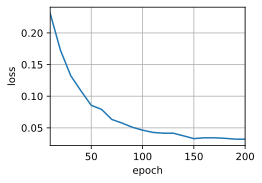

In [164]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

print(f"num_hiddens is {num_hiddens}\n"
      f"num_layers is {num_layers}\n"
      f"ffn_num_input is {ffn_num_input}\n"
      f"ffn_num_hiddens is {ffn_num_hiddens}\n"
      f"num_heads is {num_heads}\n")


train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [166]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, False)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est riche .,  bleu 0.658
i'm home . => je suis chez moi ici <unk> chez moi ici <unk>,  bleu 0.481
